In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
from tqdm import tqdm
from dasr.asr import Wav2VecEnv
from dasr.datasets import get_common_voice
from dasr.datasets import RandomNoiseSNR

from dasr.train.pl_model import DASRModel
from dasr.train.pl_tune_w2v import ASRModel
from dasr.datasets.make_dataloaders import CollateWithPadd
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import os
import re
import math

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

In [4]:
from torchmetrics.text import CharErrorRate, WordErrorRate

def normalize_text(text: str):
    if isinstance(text, float) and math.isnan(text): # if an input text is empty, then we return an empty text too
        return ''
    
    for char in [".", ",", "!", "?", "(", ")"]:
        text = text.replace(char, " ")
    text = text.replace("ё", "е")
    text = re.sub(" +", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    return text

def normalize_df(df, column_names = ["transcription", "gt"]):
    for colname in column_names:
        df[colname] = df[colname].apply(normalize_text) 
        
    return df

def calculate_error_rates(target, preds):
    wer = WordErrorRate()
    cer = CharErrorRate()
    
    return wer(target=target, preds=preds).item(), cer(target=target, preds=preds).item()

def get_common_voice_datasets(train_split="train[0:20000]",
                              test_split="test[0:5000]",
                              desire_snr_range_db=[10, 10],
                              language="en"):
    
    common_voice = get_common_voice(train_split=train_split,
                                    test_split=test_split,
                                    language=language)
    
    # train_dataset = RandomNoiseSNR(common_voice["train"], desire_snr_range_db=desire_snr_range_db)
    test_dataset = RandomNoiseSNR(common_voice["test"], desire_snr_range_db=desire_snr_range_db)
    
    return test_dataset

In [5]:
collate_fn = CollateWithPadd().collate_fn

# Zero-Shot русского денойзера для английского wav2vec

In [6]:
# RU Лучший денойзер (размороженный полносью)
path_best_ru = "./../../checkpoints/[only ctc] wav2vec+pretrained_dns64 [lr=1e-4] (unfreeze), SNR=10, train[0:20000]/epoch=22.ckpt"

# RU Лучший денойзер с замороженным энкодером
# path_best_ru = "/home/docker_current/dasr/checkpoints/[only ctc] wav2vec+pretrained_dns64 [lr=1e-4] (freeze encoder), SNR=10, train[0:20000] second run/epoch=64.ckpt"

model_ru = DASRModel.load_from_checkpoint(path_best_ru)

# EN Лучший денойзер 
path_best_en = "/home/docker_current/dasr/checkpoints/EN [ctc] wav2vec2+pretrained_dns64 [lr=1e-4] (unfreeze), SNR in [10, 10], train[0:20000]/epoch=31.ckpt"
model_en = DASRModel.load_from_checkpoint(path_best_en)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [7]:
# Меняем денойзер английской модели на дейнозер от русской модели
model_en.model = model_ru.model

In [8]:
train_split = "train[0:10]"
test_split = "test[0:5000]"

test_dataset = get_common_voice_datasets(train_split=train_split,
                                         test_split=test_split, 
                                         language="en")

test_loader = DataLoader(
            test_dataset,
            batch_size=16,
            collate_fn=collate_fn,
            shuffle=False,
            num_workers=5,
        )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset 

In [9]:
trainer = pl.Trainer(
    accelerator="cuda",
)

outputs = trainer.predict(model_en, test_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100 80

Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
transcripts = []
for i in outputs:
    asr_output = i[0]
    pred_ids = torch.argmax(asr_output.logits, dim=-1)
    denoisy_transcript = model_en.asr.processor.batch_decode(pred_ids)
    transcripts.extend(denoisy_transcript)
    
gts = test_dataset.transcriptions

In [11]:
df = pd.DataFrame({"transcription": transcripts, "gt": gts})
df.head(2)

,transcription,gt
0,toughkeeplen disapproved of films and buster a...,"Joe Keaton disapproved of films, and Buster al..."
1,shed be all right,She'll be all right.


In [12]:
df = normalize_df(df)
calculate_error_rates(df["gt"], df["transcription"])

(0.3625791370868683, 0.18204881250858307)

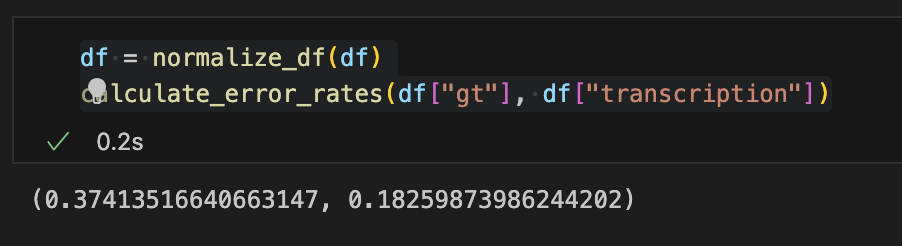

# Zero-Shot английского денойзера для русского wav2vec

In [6]:
# RU Лучший денойзер 
path_best_ru = "/home/docker_current/dasr/checkpoints/[only ctc] wav2vec+pretrained_dns64 [lr=1e-4] (freeze encoder), SNR=10, train[0:20000] second run/epoch=64.ckpt"
model_ru = DASRModel.load_from_checkpoint(path_best_ru)

# EN Лучший денойзер (размороженный полносью)
path_best_en = "/home/docker_current/dasr/checkpoints/EN [ctc] wav2vec2+pretrained_dns64 [lr=1e-4] (unfreeze), SNR in [10, 10], train[0:20000]/epoch=31.ckpt"
# EN Лучший денойзер с замороженным энкодером
# path_best_en = "/home/docker_current/dasr/checkpoints/EN [ctc] wav2vec2+pretrained_dns64 [lr=1e-4] (freeze encoder), SNR in [10, 10], train[0:20000]/epoch=47.ckpt"

model_en = DASRModel.load_from_checkpoint(path_best_en)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


Freezing encoder


In [7]:
# Меняем денойзер русской модели на дейнозер от английской модели
model_ru.model = model_en.model

In [14]:
train_split = "train[0:10]"
test_split = "test"

test_dataset = get_common_voice_datasets(train_split=train_split,
                                         test_split=test_split, 
                                         language="ru")

test_loader = DataLoader(
            test_dataset,
            batch_size=16,
            collate_fn=collate_fn,
            shuffle=False,
            num_workers=5,
        )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [15]:
trainer = pl.Trainer(
    accelerator="cuda",
)

outputs = trainer.predict(model_ru, test_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2, 3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
transcripts = []
for i in outputs:
    asr_output = i[0]
    pred_ids = torch.argmax(asr_output.logits, dim=-1)
    denoisy_transcript = model_ru.asr.processor.batch_decode(pred_ids)
    transcripts.extend(denoisy_transcript)
    
gts = test_dataset.transcriptions

In [17]:
df = pd.DataFrame({"transcription": transcripts, "gt": gts})
df.head(5)

,transcription,gt
0,сожаление эти предложений неносли отражения в ...,"К сожалению, эти предложения не нашли отражени..."
1,если не будет возражений я буду считать что ас...,"Если не будет возражений, я буду считать, что ..."
2,новашафкин милый город,Новошахтинск — милый город
3,ну особенно раду отнуть что числы шисят в соа...,"Мы особенно рады отметить, что число скрывающи..."
4,контролер,Контроллер


In [18]:
df = normalize_df(df)
calculate_error_rates(df["gt"], df["transcription"])

(0.32411324977874756, 0.10510701686143875)